# O Problema

Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para criar uma série temporal e prever diariamente o fechamento da base.

Para isso utilize a base de dados contida no site da investing e selecione o período "diário", com o intervalo de tempo que achar adequado.

Você precisará demonstrar para o time de investimentos:

* O modelo com o storytelling, desde a captura do dado até a entrega do modelo;
* Justificar a técnica utilizada;
* Atingir uma acuracidade adequada (acima de 70%).

# Compreenção dos dados para análise

Os dados obtidos do site https://br.investing.com/indices/bovespa-historical-data para o período de 2019 a 2024 incluem as seguintes informações:

*	**Data:** a data em que os dados foram registrados.
*	**Último:** o preço de fechamento do índice Bovespa naquela data.
*	**Abertura:** o preço de abertura do índice Bovespa naquela data.
*	**Máxima:** o preço máximo atingido pelo índice Bovespa naquela data.
*	**Mínima:** o preço mínimo atingido pelo índice Bovespa naquela data.
*	**Vol.:** o volume de negociações do índice Bovespa naquela data, em milhões.
*	**Var%:** a variação percentual do índice Bovespa em relação ao dia anterior.

A análise dos dados disponibilizados revela que são informações valiosas para prever o comportamento futuro do índice Bovespa, sendo essenciais para o desenvolvimento de modelos de Machine Learning.

# Bibliotecas imports

In [183]:
!pip install pmdarima

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from datetime import datetime, timedelta

# ARIMA
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from pmdarima.arima.utils import ndiffs

# prophet
from prophet import Prophet # forecasting at scale
from prophet.plot import plot_plotly

# Ridge Regression
from sklearn.linear_model import Ridge

# LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings("ignore")

# Carregamento dos Dados




Utilizando a biblioteca pandas para ler um arquivo CSV contendo dados da IBOVESPA (Bolsa de Valores de São Paulo) que abrange o período de 15/02/2014 a 15/02/2024. O arquivo está sendo lido a partir de uma URL pública usando o método pd.read_csv(), e os dados são armazenados em um DataFrame chamado df_bovespa.

In [185]:
# dados bovespa de 15/02/2014 a 15/02/2024
df_bovespa = pd.read_csv('https://raw.githubusercontent.com/karinaguerra/postech-data-analytics-tech-challenge/main/fase_2/dados/dados_ibovespa.csv')
df_bovespa.head(3)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,15.02.2024,127.804,127.018,127.824,126.932,"10,98M","0,62%"
1,14.02.2024,127.018,128.026,128.026,126.663,"7,75M","-0,79%"
2,09.02.2024,128.026,128.216,128.896,127.579,"12,12M","-0,15%"


# 1.Verificação e tratamento dos dados

## 1.1 Dimenção dos dados

Total de dados coletados são:
*   1242 linhas
*   7 colunas

In [186]:
df_bovespa.shape

(1242, 7)

## 1.2 Verificar Data types

Verificar os tipos de dados (dtypes) é útil para entender a composição dos seus dados e identificar possíveis problemas, como valores ausentes ou a necessidade de conversões. Neste caso, temos 3 colunas do tipo object que podem precisar de conversão: a coluna de data para datetime e as colunas de "Vol." e "Var%" para float ou int.

In [187]:
df_bovespa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242 entries, 0 to 1241
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      1242 non-null   object 
 1   Último    1242 non-null   float64
 2   Abertura  1242 non-null   float64
 3   Máxima    1242 non-null   float64
 4   Mínima    1242 non-null   float64
 5   Vol.      1242 non-null   object 
 6   Var%      1242 non-null   object 
dtypes: float64(4), object(3)
memory usage: 68.0+ KB


## 1.3 Valores nulos e duplicados

Outro ponto importante é verificar se existem valores nulos em cada coluna do DataFrame df_bovespa. Isso pode ser feito usando o método isnull(), que cria um DataFrame booleano indicando onde os valores são nulos. Em seguida, utiliza-se o método sum() para somar o número de valores True em cada coluna, o que corresponde ao número de valores nulos.


In [188]:
df_bovespa.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64

Para verificar os valores duplicados, você pode usar o método duplicated(), que retorna uma série booleana indicando se cada linha é uma duplicata da linha anterior. Em seguida, você pode usar o método sum() para contar o número total de duplicatas.

In [189]:
df_bovespa.duplicated().sum()

0

## 1.4 Tratamento de dados do data frame

Para a limpeza e ajuste dos dados foi criada uma função limpar_dados_bovespa(df_dados) que recebe um DataFrame df_dados como entrada e realiza as seguintes operações de limpeza e preparação dos dados:

1. Renomeia as colunas do DataFrame para nomes mais descritivos.
2. Converte a coluna 'data' para o tipo datetime.
3. Ordena os dados por data, do mais antigo para o mais recente.
4. Reseta o índice do DataFrame e define a coluna 'data' como índice.
5. Remove caracteres de texto da coluna 'perc_variavel' e converte para float.
6. Remove caracteres de texto da coluna 'volume', converte para numérico e ajusta a escala para valores de volume em milhões.

Após definir a função, ela é aplicada ao DataFrame df_bovespa, realizando a limpeza e preparação dos dados.

In [190]:
def limpar_dados_bovespa(df_dados):
    # Renomear colunas
    df_dados.rename(columns={
        'Data': 'data',
        'Último': 'ultimo',
        'Abertura': 'abertura',
        'Máxima': 'maxima',
        'Mínima': 'minima',
        'Vol.': 'volume',
        'Var%' : 'perc_variavel'
    }, inplace=True)

    # Tranformar coluna data em datetime
    df_dados['data'] = pd.to_datetime(df_dados['data'], format='%d.%m.%Y')

    # ordenar os dados por data (do mais antigo para o mais atual)
    df_dados.sort_values(by=['data'], ascending=True, inplace=True)

    # resetar o index
    df_dados.reset_index(drop=True,inplace=True)
    df_dados.set_index('data', inplace=True)

    # Retirar os caracteres de texto das colunas perc_variavel e converter
    df_dados['perc_variavel'] = df_dados['perc_variavel'].str.replace('%','').str.replace(',','.').astype(float)

# Aplicar a limpeza nos dois DataFrames
limpar_dados_bovespa(df_bovespa)

In [191]:
# Função para converter strings com sufixo M ou K para inteiros
def converter_volume(volume_str):
    if 'M' in volume_str:
        volume_str = volume_str.replace('M', '').replace(',', '.')  # Remover o sufixo 'M' e substituir ',' por '.'
        return int(float(volume_str) * 1000000)  # Converter para int multiplicando por 1 milhão
    elif 'K' in volume_str:
        volume_str = volume_str.replace('K', '').replace(',', '.')  # Remover o sufixo 'K' e substituir ',' por '.'
        return int(float(volume_str) * 1000)  # Converter para int multiplicando por 1000
    else:
        return 0  # Retornar 0 se não houver sufixo válido

# Converter os valores da coluna 'volume' para strings
df_bovespa['volume'] = df_bovespa['volume'].astype(str)

# Aplicar a função de conversão à coluna 'volume'
df_bovespa['volume'] = df_bovespa['volume'].apply(converter_volume)

## 1.5 Validar tratativas e alterações

In [192]:
df_bovespa.columns

Index(['ultimo', 'abertura', 'maxima', 'minima', 'volume', 'perc_variavel'], dtype='object')

In [193]:
df_bovespa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1242 entries, 2019-02-15 to 2024-02-15
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ultimo         1242 non-null   float64
 1   abertura       1242 non-null   float64
 2   maxima         1242 non-null   float64
 3   minima         1242 non-null   float64
 4   volume         1242 non-null   int64  
 5   perc_variavel  1242 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 67.9 KB


# 2.Análise Exploratória dos Dados (EDA)


EDA abordagem para analisar conjuntos de dados a fim de resumir suas principais características, muitas vezes com métodos visuais. O objetivo da EDA é explorar os dados, entender seus padrões, identificar relações entre as variáveis e formular hipóteses para investigação adicional.

Definindo um periodo de ('2019-02-15 00:00:00'), ('2024-02-15 00:00:00')

In [194]:
df1_bovespa = df_bovespa.copy()

In [195]:
df1_bovespa.index.min(), df1_bovespa.index.max(),

(Timestamp('2019-02-15 00:00:00'), Timestamp('2024-02-15 00:00:00'))

## 2.1 Visualização completa do dados

A cria um gráfico de linha e um histograma para visualizar o conjunto de dados df1_bovespa.

O primeiro gráfico mostra o preço de fechamento da Bovespa ao longo dos anos.

In [196]:
# Grafico de linha para visualizar o data set completo
fig1 = px.line(df1_bovespa, x=df1_bovespa.index, y='ultimo')

fig1.update_traces(line_color='steelblue')

# layout
fig1.update_layout(title='Preço de Fechamento da Bovespa ao Longo dos Anos',
                   xaxis_title='Período',
                   yaxis_title='Fechamento ibovespa')

fig1.show()

## 2.2 Analise temporal dos dados

In [197]:
# DataFrame com os pontos de destaque e suas legendas
pontos_destaque = [
    {'data': '2020-03-23', 'destaque': df1_bovespa.loc['2020-03-23', 'ultimo'],'legenda': '1 Covid-19'},
    {'data': '2020-10-30', 'destaque': df1_bovespa.loc['2020-10-30', 'ultimo'],'legenda': '2 Segunda Onda'},
    {'data': '2021-06-07', 'destaque': df1_bovespa.loc['2021-06-07', 'ultimo'],'legenda': '3 Desinflação'},
    {'data': '2022-07-14', 'destaque': df1_bovespa.loc['2022-07-14', 'ultimo'],'legenda': '4 Recessão EUA'},
    {'data': '2023-12-28', 'destaque': df1_bovespa.loc['2023-12-28', 'ultimo'],'legenda': '5 Max histórica'}
]

df_pontos_destaque = pd.DataFrame(pontos_destaque)

# Criar o gráfico de linha
fig1 = px.line(df1_bovespa, x=df1_bovespa.index, y='ultimo')
fig1.update_traces(line_color='steelblue')

# Adicionar os pontos de destaque
fig1.add_trace(px.scatter(df_pontos_destaque, x='data', y='destaque').data[0])

# Adicionar anotações para cada ponto de destaque com fundo colorido
for ponto in pontos_destaque:
    fig1.add_annotation(x=ponto['data'], y=ponto['destaque'],
                        xshift=61, # Deslocamento para a direita
                        text=ponto['legenda'],
                        showarrow=False,
                        font=dict(color='white'),
                        bgcolor='tomato',
                        bordercolor='tomato',
                        borderwidth=1,
                        borderpad=4)

# Personalizar cores e marcadores dos pontos de destaque
fig1.update_traces(marker=dict(color='tomato', size=10, symbol='0'))

# Personalizar layout do gráfico
fig1.update_layout(title='Preço de Fechamento da Bovespa ao Longo dos Anos',
                   xaxis_title='Período',
                   yaxis_title='Fechamento ibovespa')

fig1.show()

In [198]:
fig2 = px.histogram(df1_bovespa, x='ultimo', nbins=30, opacity=0.7,
                   marginal='violin',
                    color_discrete_sequence=['steelblue'])

# layout
fig2.update_layout(title_font_size=12,
                   xaxis_title_font_size=10,
                   yaxis_title_font_size=10,
                   title='Distribuição do Fechamento',
                   xaxis_title='Fechamento ibovespa',
                   yaxis_title='Densidade')

# Mostrar o gráfico
fig2.show()

## 2.3 Matriz de Correlação

A correlação é uma medida estatística que descreve a relação entre duas variáveis, varia de -1 a 1, onde:

* 1 indica uma correlação positiva perfeita: à medida que uma variável aumenta, a outra variável também aumenta na mesma proporção.
* -1 indica uma correlação negativa perfeita: à medida que uma variável aumenta, a outra variável diminui na mesma proporção.
* 0 indica que não há correlação linear entre as variáveis.

Como e possivel ver na imagem abaixo a matriz de correlação mostra as correlações entre todas as variáveis em um conjunto de dados. E isso e util porque:

1. **Identifica relações entre variáveis:** Permite identificar se duas variáveis estão relacionadas e qual é a direção dessa relação.

2. **Seleção de variáveis:** Ajuda a escolher as variáveis mais relevantes para análises mais aprofundadas, e eliminando variáveis altamente correlacionadas.

3. **Diagnóstico de modelos:** Pode ser usado para diagnosticar problemas de multicolinearidade em modelos estatísticos, onde variáveis independentes estão altamente correlacionadas.

Em resumo, a matriz de correlação é uma ferramenta importante na análise de dados para entender as relações entre variáveis e tomar decisões informadas com base nessas relações. No grafico podemos observar que as colunas ultimo, abertura, maxima, minima do nosso data frame possuel alta correlação enquando a volume, perc_variavel uma baixa correlação com as demais.

In [199]:
# Criar a matriz de correlação
correlation = df1_bovespa.corr()

# Criar o gráfico de heatmap
fig = px.imshow(correlation, color_continuous_scale='blues', text_auto=True, aspect='auto')
fig.update_layout(title='Matriz de Correlação',
                  xaxis_title=' ',
                  yaxis_title=' ',
                  xaxis_showticklabels=True,
                  yaxis_showticklabels=True)
fig.show()

## 2.4 Distribuição de um conjunto de dados (Outliers)

Os box plots são uma ferramenta gráfica útil para visualizar a distribuição de um conjunto de dados e identificar valores discrepantes (outliers). Eles fornecem uma representação compacta das principais estatísticas descritivas de um conjunto de dados, incluindo a mediana, quartis, intervalo interquartil (IQR) e potenciais outliers.

Para este caso utilizamos para a identificação de outliers, os outliers são pontos de dados que estão significativamente afastados do restante do conjunto de dados. Os box plots mostram esses pontos como pontos individuais fora dos "whiskers" do gráfico, facilitando a identificação visual dos outliers.

In [200]:
# Criar subplots
fig = make_subplots(rows=1, cols=len(df1_bovespa.columns), subplot_titles=df1_bovespa.columns)

# Adicionar box plots a cada subplot
for i, col in enumerate(df1_bovespa.columns, start=1):
    fig.add_trace(px.box(df1_bovespa, y=col).data[0], row=1, col=i)

# Cor
fig.update_traces(marker_color='steelblue', boxmean=True)

# Atualizar layout
fig.update_layout(title='Distribuição de um conjunto de dados', showlegend=False)

# Mostrar o gráfico
fig.show()


## 2.5 Gráficos de dispersão

O gráficos de dispersão também e um gráfico para visualizar as relações entre pares de variáveis no DataFrame, similar ao  matriz de correlação. Onde cada célula do grid mostra a relação entre duas variáveis, enquanto a diagonal principal mostra um histograma para cada variável individualmente.

E assim como na matriz de correlação o gráfico mostra a alta correlação das colunas ultimo, abertura, maxima, minima, enquando a volume, perc_variavel uma baixa correlação com as demais.

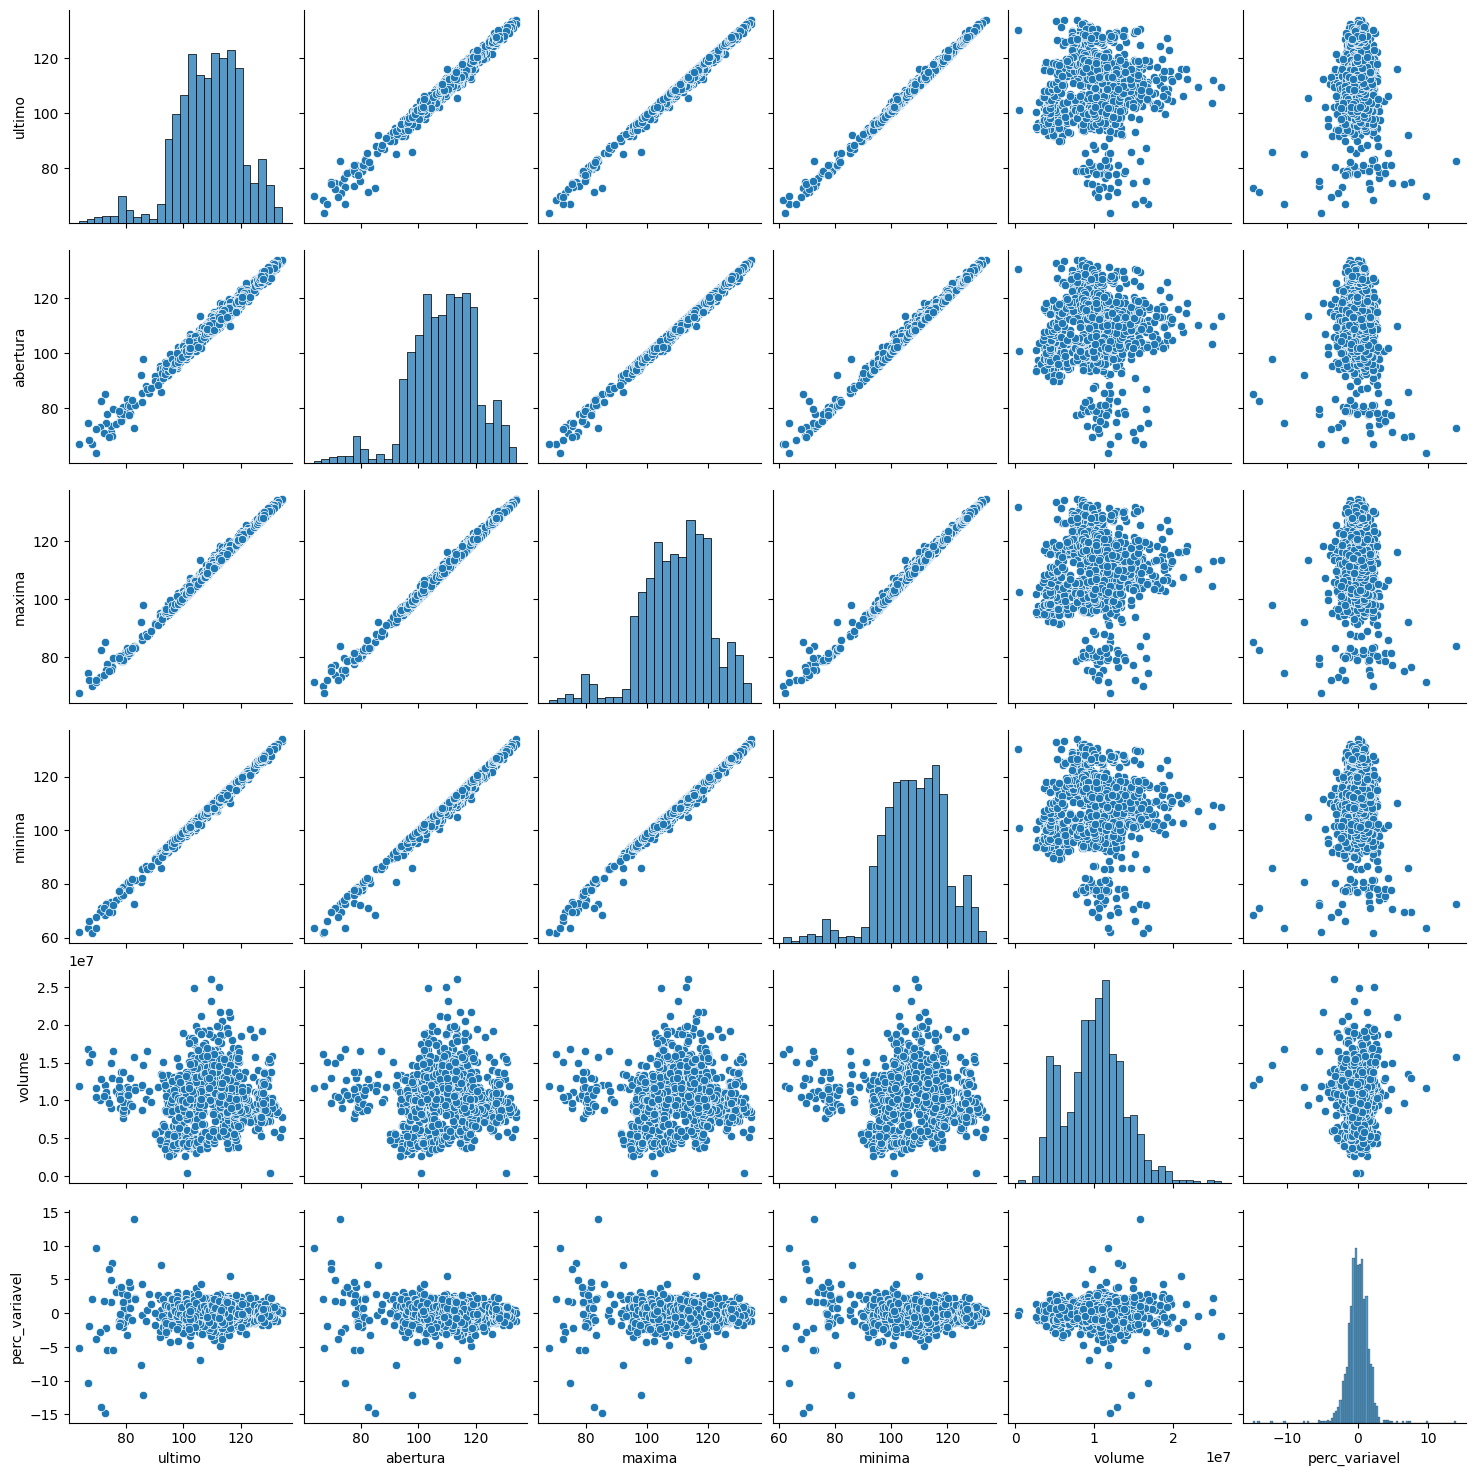

In [201]:
sns.pairplot(df1_bovespa)

## 2.6 Decomposição sazonal

A decomposição sazonal é importante porque ajuda a entender a estrutura temporal dos dados, especialmente quando há variações periódicas relacionadas a estações, meses, dias da semana, entre outras coisa.

A decomposição sazonal é uma ferramenta útil que separa a série em diferentes componentes, como observado, tendência, sazonalidade e resíduos, permitindo visualizar como cada um desses componentes contribui para a série como um todo.

Isso pode ajudar a identificar padrões sazonais, avaliar a magnitude da sazonalidade e é uma técnica importante para analisar e modelar séries temporais, especialmente aquelas que exibem variações sazonais regulares.

Ajustar modelos de previsão para considerar esses padrões de forma mais precisa.


In [202]:
# criar data frame de decomposição sazonal
df_seasonal = df1_bovespa.copy()
df_seasonal = (df_seasonal[['ultimo']])

In [203]:
df_seasonal.head(3)

,ultimo
data,
2019-02-15,97.526
2019-02-18,96.510
2019-02-19,97.659


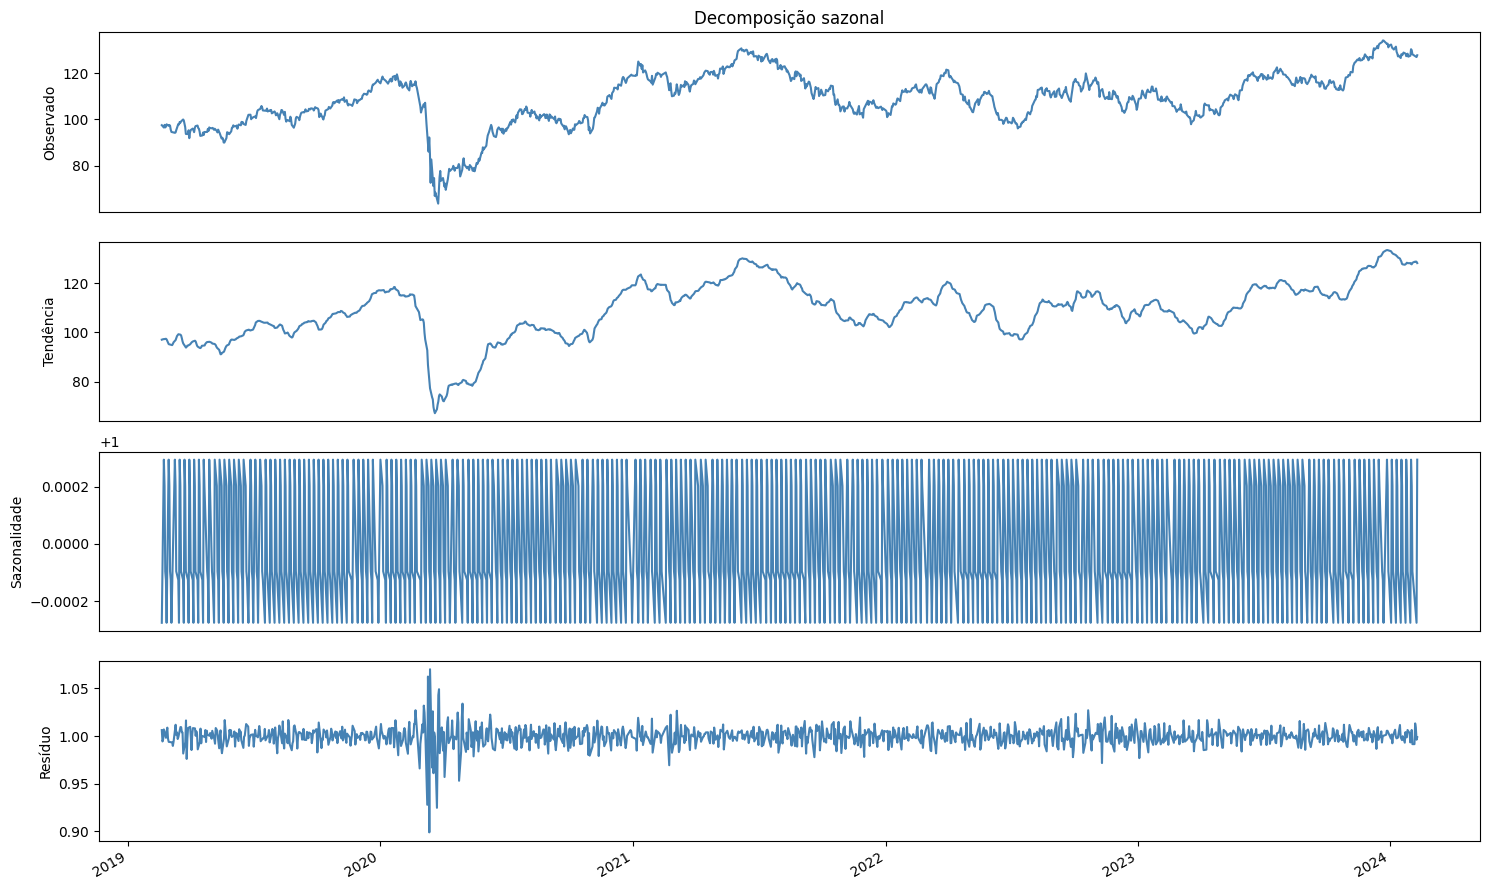

In [204]:
# Criar grafico de decomposição sazonal
seasonal_plot = seasonal_decompose(df_seasonal, model='multiplicative', period=5)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 9))

# Observado
seasonal_plot.observed.plot(ax=ax1,color='steelblue')
ax1.set_ylabel('Observado')
ax1.set_xlabel('')
ax1.set_xticks([])
ax1.grid(False)
ax1.set_title('Decomposição sazonal')

# Tendência
seasonal_plot.trend.plot(ax=ax2,color='steelblue')
ax2.set_ylabel('Tendência')
ax2.set_xlabel('')
ax2.set_xticks([])
ax2.grid(False)

# Sazonalidade
seasonal_plot.seasonal.plot(ax=ax3,color='steelblue')
ax3.set_ylabel('Sazonalidade')
ax3.set_xlabel('')
ax3.set_xticks([])
ax3.grid(False)

# Resíduo
seasonal_plot.resid.plot(ax=ax4, color='steelblue')
ax4.set_ylabel('Resíduo')
ax4.set_xlabel('')
ax4.grid(False)

plt.tight_layout()

Ao analisar o garfico e possivel ver que a tendência da série mostra uma semelhança com o próprio desenho da série original, indicando uma falta de tendência clara em uma direção específica.

Já a sazonalidade se mostra uma forma complexa devido à natureza dos índices econômicos, que apresentam variações diárias, dificultando a observação de padrões repetitivos.

Ao examinarmos os resíduos, notamos um ruído significativo no início da série, causado pela queda drástica no valor de fechamento do índice Bovespa em março de 2020, decorrente da pandemia de Covid.

## 2.7 Série Estacionária


A série estacionária é um conceito importante em estatística e análise de séries temporais. Uma série estacionária é aquela em que as propriedades estatísticas, como média, variância e autocorrelação, são constantes ao longo do tempo.

Verificar a série estacionária é importe porque muitos modelos estatísticos e técnicas de previsão de séries temporais assumem a estacionariedade dos dados. Quando uma série é estacionária, é mais fácil identificar padrões e fazer previsões precisas. Além disso, a estacionariedade muitas vezes simplifica a análise estatística, permitindo o uso de métodos mais diretos e eficazes.

Foi analisado a correlação entre 2 períodos constantes, utilizado o teste de Dickey Fuller para verificar se nossa série é estacionária ou não.

* H0 -> Série não estacionária (p-value > 0.05)
* H1 -> Série estacionária (p-value <= 0.05)

Para modelos ARIMA a estacionariedade dos dados é um requisito importante. Se os dados não são estacionários, é necessário aplicar diferenciação para torná-los estacionários antes de ajustar treinar o modelo.

In [205]:
df = df_seasonal.copy()

In [206]:
# Teste de Dickey Fuller
result = adfuller(df['ultimo'])
print('Teste de Dickey-Fuller Aumentado:')
print(f'Teste ADF: {result[0]}')
print(f'p-valor: {result[1]}')
print('Valores críticos:')
for key, value in result[4].items():
  print(f'\t{key}: {value}')

if result[1] <= 0.05:
  print('Conclusão: A série temporal provavelmente é estacionária.')
else:
  print('Conclusão: A série temporal provavelmente não é estacionária.')

Teste de Dickey-Fuller Aumentado:
Teste ADF: -2.6231691221836604
p-valor: 0.08830260139751994
Valores críticos:
	1%: -3.4356646522289815
	5%: -2.863886926389418
	10%: -2.568019536239491
Conclusão: A série temporal provavelmente não é estacionária.


Neste caso, como o teste ADF sugere que a série temporal não é estacionária (p-valor maior que 0.05), então é preciso aplicar diferenciação para tornar a série estacionária antes de prosseguir com o modelo. A diferenciação envolve subtrair os valores de um período dos valores do período anterior para remover tendências ou padrões de sazonalidade.

Depois de aplicar a diferenciação e obter uma série estacionária, e possivel usar métodos como a análise da autocorrelação (ACF) e da autocorrelação parcial (PACF) para determinar os parâmetros p, d e q do modelo ARIMA. Estes representam a ordem da parte autoregressiva, a ordem de diferenciação e a ordem da média móvel, respectivamente.

Em resumo, a não estacionariedade da série temporal indica que é necessário aplicar diferenciação antes de modelar com ARIMA.

Text(0.5, 1.0, 'Dados Original (ibovespa)')

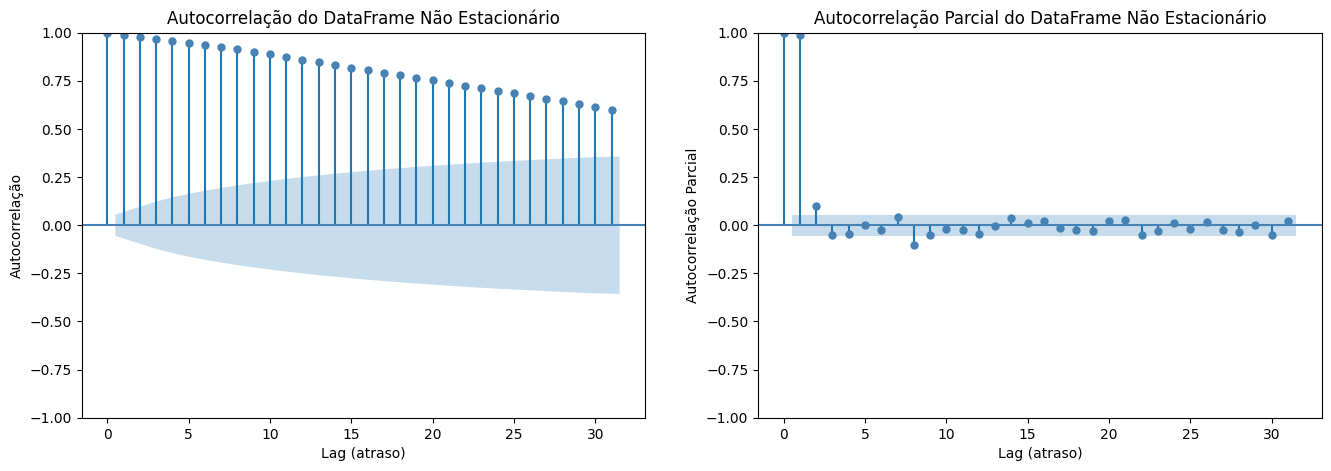

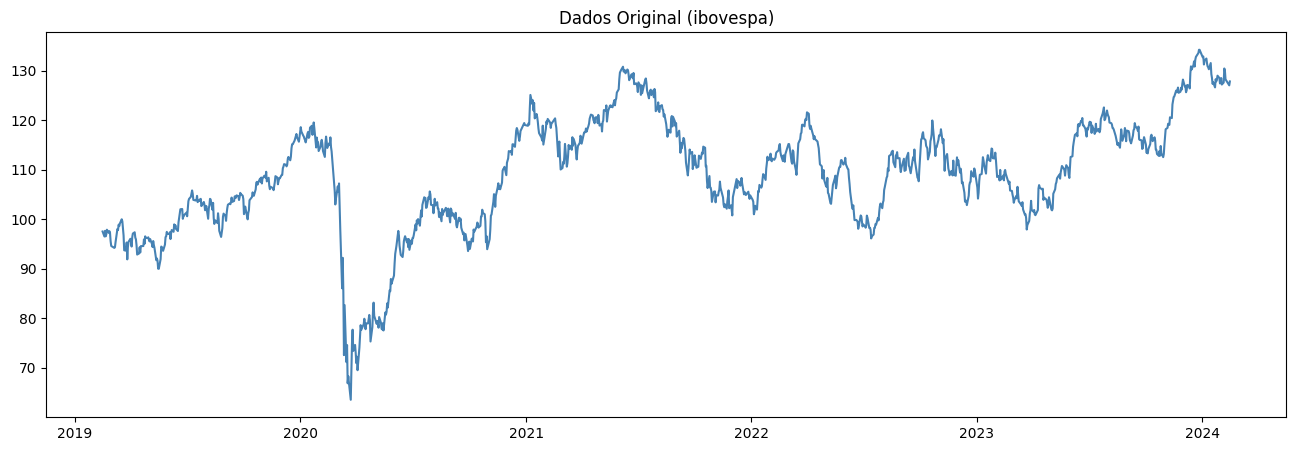

In [207]:
fz = figsize=(16, 5)

# Criar a figura e os subplots
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize = fz)
fig2, (ax3) = plt.subplots(1, 1, figsize = fz)

# Plotar o gráfico de autocorrelação
plot_acf(df.ultimo, color='steelblue', ax=ax1)
ax1.set_title('Autocorrelação do DataFrame Não Estacionário')
ax1.set_xlabel('Lag (atraso)')
ax1.set_ylabel('Autocorrelação')

# Plotar o gráfico de autocorrelação parcial
plot_pacf(df.ultimo, color='steelblue', ax=ax2)
ax2.set_title('Autocorrelação Parcial do DataFrame Não Estacionário')
ax2.set_xlabel('Lag (atraso)')
ax2.set_ylabel('Autocorrelação Parcial')

# Plotar o gráfico dos dados originais
ax3.plot(df.ultimo, color='steelblue')
ax3.set_title('Dados Original (ibovespa)')

## 2.8 Diferenciação (diff)


In [208]:
# O número de diferenciações não sazonais sugeridas para tornar a série estacionária
ndiffs(df.ultimo, test='adf')

1

In [209]:
# Calcula a diferença entre os elementos
df_stationary = df.copy()
df_stationary['ultimo'] = df_stationary['ultimo'].diff()
df_stationary.dropna(inplace=True)

In [210]:
# Teste de Dickey Fuller
result_diff = adfuller(df_stationary['ultimo'])
print('Teste de Dickey-Fuller Aumentado:')
print(f'Teste ADF: {result_diff[0]}')
print(f'p-valor: {result_diff[1]}')
print('Valores críticos:')
for key, value in result_diff[4].items():
  print(f'\t{key}: {value}')

if result_diff[1] <= 0.05:
  print('Conclusão: A série temporal provavelmente é estacionária.')
else:
  print('Conclusão: A série temporal provavelmente não é estacionária.')

Teste de Dickey-Fuller Aumentado:
Teste ADF: -10.806515933553417
p-valor: 1.9570324233203174e-19
Valores críticos:
	1%: -3.4356646522289815
	5%: -2.863886926389418
	10%: -2.568019536239491
Conclusão: A série temporal provavelmente é estacionária.


Conclusão: A série temporal provavelmente é estacionária, pois o p-valor (1.9570324233203174e-19) é menor que 0.05 (um nível comum de significância estatística). Isso sugere que há evidências suficientes para rejeitar a hipótese nula de que a série possui raiz unitária e, portanto, é estacionária após a diferenciação.

Para visualizar a diferenciação aplicada à série temporal, foi criado um gráfico que inclui a média móvel e o desvio padrão. A média móvel suaviza a série, destacando tendências de longo prazo, enquanto o desvio padrão mostra a variabilidade dos dados ao longo do tempo. Juntos, esses elementos ajudam a visualizar melhor as características da série diferenciada.




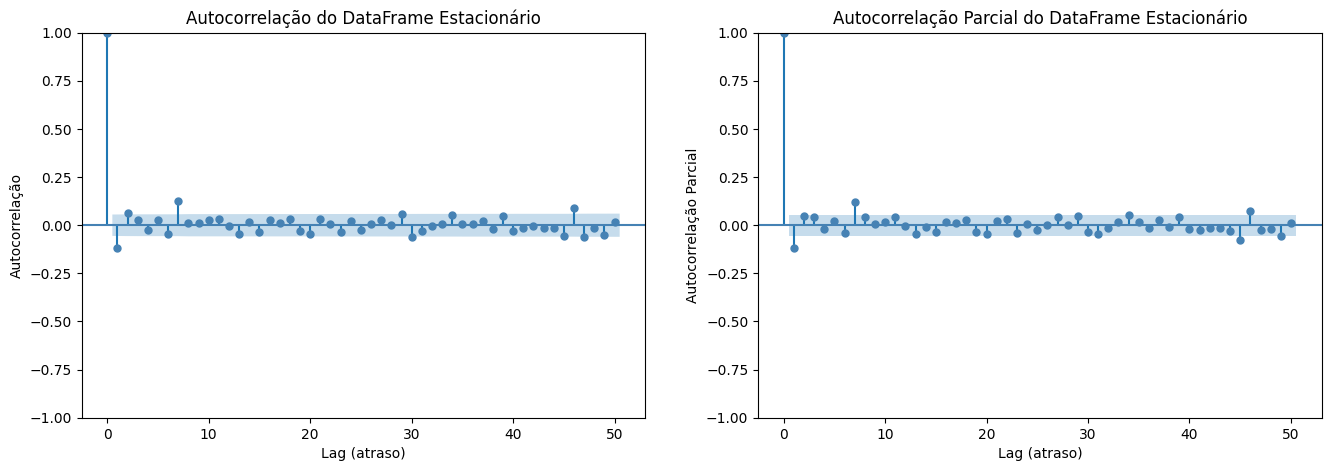

In [211]:
# Criar a figura e os subplots
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plotar o gráfico de autocorrelação
plot_acf(df_stationary.ultimo, lags=50, color='steelblue', ax=ax1)
ax1.set_title('Autocorrelação do DataFrame Estacionário')
ax1.set_xlabel('Lag (atraso)')
ax1.set_ylabel('Autocorrelação')

# Plotar o gráfico de autocorrelação parcial
plot_pacf(df_stationary.ultimo, lags=50, color='steelblue', ax=ax2)
ax2.set_title('Autocorrelação Parcial do DataFrame Estacionário')
ax2.set_xlabel('Lag (atraso)')
ax2.set_ylabel('Autocorrelação Parcial');

In [212]:
# Media movel
mm_diff = df_stationary.rolling(12).mean()

# desvio padrão ao gráfico
dp_diff = df_stationary.rolling(12).std()

# Criar figura
fig = go.Figure()

# Adicionar série original ao gráfico com cor 'blue'
fig.add_trace(go.Scatter(x=df_stationary.index, y=df_stationary['ultimo'], mode='lines', name='Série Diferenciada', line_color='steelblue'))

# Adicionar média móvel ao gráfico com cor 'green'
fig.add_trace(go.Scatter(x=mm_diff.index, y=mm_diff['ultimo'], mode='lines', name='Média Móvel', line_color='tomato'))

# Adicionar desvio padrão ao gráfico com cor 'red'
fig.add_trace(go.Scatter(x=dp_diff.index, y=dp_diff['ultimo'], mode='lines', name='Desvio Padrão', line_color='limegreen'))

# Atualizar layout do gráfico
fig.update_layout(title='Diferenciação',
                   xaxis_title='Período',
                   yaxis_title='Fechamento ibovespa')

# Mostrar o gráfico
fig.show()

# 4.Modelos

## 4.1 ARIMA

ARIMA (Autoregressive Integrated Moving Average) é um modelo estatístico utilizado para analisar e prever séries temporais. Ele combina a ideia de regressão linear (parte autoregressiva), médias móveis (parte de médias móveis) e diferenciação de séries temporais (parte integrada) em um único modelo.

O modelo ARIMA é frequentemente representado como ARIMA(p, d, q), onde:

* "p" é a ordem do componente autoregressivo;
* "d" é a ordem de diferenciação;
* "q" é a ordem do componente de médias móveis.

O ARIMA é um modelo poderoso para prever séries temporais, especialmente quando a série exibe padrões complexos de autocorrelação e sazonalidade. No entanto, é importante ajustar adequadamente os parâmetros do modelo e avaliar sua precisão para obter resultados confiáveis.

###  4.1.1 Buscar os melhores parâmetros

Antes de criar o modelo ARIMA foi utilizada a função ***auto_arima*** da biblioteca ***pmdarima***. Essa função ajustar um modelo ARIMA automaticamente aos dados passados, buscando os melhores parâmetros. E para isso foi utilizado os seguintes argumentos:

> * ***d=1:*** O número de diferenciações não sazonais.
>
> * ***start_p=1, start_q=1:*** Valores iniciais para os parâmetros p e q.
>
> * ***max_p=3, max_q=3:*** Valores máximos para os parâmetros p e q.
>
> * ***seasonal=True, m=6:*** Considera sazonalidade com um período sazonal de 6.
>
> * ***D=1, start_P=1, start_Q=1:*** Valores iniciais para os parâmetros sazonais P e Q.
>
> * ***max_P=2, max_Q=2:*** Valores máximos para os parâmetros sazonais P e Q.
>
> * ***information_criterion='aic':*** Critério de informação para selecionar o melhor modelo, utizado o Critério de Informação de Akaike (AIC) é uma medida estatística que quantifica a qualidade relativa de um modelo estatístico para um conjunto dado de dados.
>
> * ***trace=True:*** Mostra informações detalhadas sobre o processo de ajuste.
> * ***error_action='ignore':*** Ignora erros durante o ajuste.
>
> * ***stepwise=True:*** Usa um método stepwise para encontrar os melhores parâmetros.

O ***auto_arima*** irá ajustar vários modelos ARIMA com diferentes combinações de parâmetros e selecionar o melhor modelo com base no critério de informação especificado. Isso ajuda a encontrar automaticamente os melhores parâmetros para o modelo ARIMA sem a necessidade de ajuste manual.

In [213]:
# Auto ARIMA nos ajuda a buscar os melhores parâmetros
fit_arima = auto_arima(df, d=1, start_p=1, start_q=1, max_p=3, max_q=3, seasonal=True, m=6,
                       D=1, start_P=1,start_Q=1,  max_P=2, max_Q=2, information_criterion='aic',
                       trace=True,  error_action='ignore', stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=inf, Time=10.07 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=5604.569, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=5198.227, Time=0.50 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=inf, Time=5.26 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=5563.103, Time=0.34 sec
 ARIMA(1,1,0)(2,1,0)[6]             : AIC=5027.008, Time=1.18 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=inf, Time=5.23 sec
 ARIMA(1,1,0)(1,1,1)[6]             : AIC=inf, Time=2.27 sec
 ARIMA(0,1,0)(2,1,0)[6]             : AIC=5042.472, Time=0.30 sec
 ARIMA(2,1,0)(2,1,0)[6]             : AIC=5026.029, Time=0.55 sec
 ARIMA(2,1,0)(1,1,0)[6]             : AIC=5198.927, Time=0.32 sec
 ARIMA(2,1,0)(2,1,1)[6]             : AIC=inf, Time=6.12 sec
 ARIMA(2,1,0)(1,1,1)[6]             : AIC=inf, Time=3.47 sec
 ARIMA(3,1,0)(2,1,0)[6]             : AIC=5025.710, Time=0.67 sec
 ARIMA(3,1,0)(1,1,0)[6]             : AIC=5198.951, Time=0.38 

Então agora para criar o modelo utlizamos o -  ***Best model:  Best model:  ARIMA(3,1,0)(2,1,0)[6]***


### 4.1.2 Separação para treino e teste (ARIMA)

In [214]:
# a variável X recebe os dados da série
X = df.ultimo
X = X.astype('float32')

In [215]:
# Separa os dados com 70% dos dados para treino e 30% dos dados para teste
size = int(len(X) * 0.7)
train = X [0:size]
test = X [size:]

In [216]:
print('train:',len(train))
print('test:', len(test))

train: 869
test: 373


A variável ***history*** foi criada para controlar os dados conforme os treinamentos e testes foram realizados com os dados subsequentes.

In [217]:
# cria a variável history
history = [x for x in train]

Criar um lista de ***predictions*** vazia

In [218]:
# cria lista de previsões
predictions = list()

Um dos requisito para modelos como ARIMA como explicado anteriormente e a estacionariedade, isso simplifica a modelagem e a previsão, pois permite que as propriedades estatísticas da série sejam consideradas estáveis ao longo do tempo.

Para este caso foram criadas duas funções a primeira ***difference*** implementa a diferenciação de uma série temporal. Isso pode ser útil para remover tendências ou padrões de sazonalidade da série. Como destacado nos graficos de correlação mostrando a diferenciação nos dados

Por outro lado, a função ***inverse_difference*** reverte o efeito da diferenciação. Ela aceita a série original antes da diferenciação ***(history)***, o valor diferenciado a ser revertido ***(previsao)***, e o intervalo de diferenciação. Essa função é útil para converter os valores diferenciados de volta para a escala original da série, o que é necessário para interpretar e avaliar as previsões feitas pelo modelo ARIMA, por exemplo.

### 4.1.3 Função para diferenciação

In [219]:
# Cria a função que faz a diferenciação
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

# cria função que reverte o valor diferenciado para o original
def inverse_difference(history, previsao, interval=1):
  return previsao + history[-interval]

### 4.1.4 Walk-Forward

In [220]:
# inicia Walk-Forward
for t in range(len(test)):

  # difference data
  days = 12
  diff = difference(history, days)

  # cria um modelo ARIMA com os dados de history (dados de treino)
  model = ARIMA(diff, order=(3,1,0))

  # treina o modelo ARIMA
  model_fit = model.fit()

  # a variável valor_predito recebe o valor previsto pelo modelo
  valor_predito = model_fit.forecast()[0]

  # valor_predito recebe o valor revertido (escala original)
  valor_predito = inverse_difference(history, valor_predito, days)

  # adiciona o valor predito na lista de predicões
  predictions.append(valor_predito)

  # a variável valor_real recebe o valor real do teste
  valor_real = test[t]

  # adiciona o valor real a variável history
  history.append(valor_real)

  # imprime valor predito e valor real
  print('Valor predito=%.3f, Valor esperado=%3.f' % (valor_predito, valor_real))

Valor predito=113.810, Valor esperado=114
Valor predito=112.636, Valor esperado=114
Valor predito=114.603, Valor esperado=114
Valor predito=114.439, Valor esperado=111
Valor predito=114.052, Valor esperado=111
Valor predito=111.321, Valor esperado=113
Valor predito=114.157, Valor esperado=113
Valor predito=113.305, Valor esperado=114
Valor predito=115.083, Valor esperado=112
Valor predito=112.093, Valor esperado=112
Valor predito=115.157, Valor esperado=110
Valor predito=111.276, Valor esperado=110
Valor predito=109.928, Valor esperado=110
Valor predito=110.117, Valor esperado=111
Valor predito=110.869, Valor esperado=112
Valor predito=109.745, Valor esperado=110
Valor predito=108.877, Valor esperado=110
Valor predito=112.181, Valor esperado=112
Valor predito=112.395, Valor esperado=113
Valor predito=113.965, Valor esperado=111
Valor predito=110.112, Valor esperado=111
Valor predito=110.309, Valor esperado=110
Valor predito=107.984, Valor esperado=109
Valor predito=108.221, Valor esper

### 4.1.5 Gráfico de Previsão

In [221]:
df_prev_arima = pd.DataFrame(test)
df_prev_arima['previsao'] = predictions

In [222]:
fig = px.line(df_prev_arima, y=['ultimo', 'previsao'],
              color_discrete_map={'ultimo': 'cadetblue','previsao': 'tomato'})

# Personalize o layout do gráfico
fig.update_layout(
    title='Fechamento ibovespa x Previsão',
    xaxis_title='Período',
    yaxis_title='Fechamento ',
    font=dict(family='Arial', size=11, color='darkslategrey'),
    legend=dict(title=''),
)

# Exiba o gráfico personalizado
fig.show()

In [223]:
df_prev_arima.tail(3)

,ultimo,previsao
data,,
2024-02-09,128.026001,128.275638
2024-02-14,127.017998,128.257138
2024-02-15,127.804001,127.810142


#### 4.1.5.1 Gráfico Residual

(array([0.01050949, 0.02942658, 0.08827973, 0.16394807, 0.20598603,
        0.18076325, 0.06726074, 0.02732468, 0.0042038 , 0.00630569]),
 array([-5.71563359, -4.44013649, -3.1646394 , -1.88914231, -0.61364521,
         0.66185188,  1.93734898,  3.21284607,  4.48834317,  5.76384026,
         7.03933735]),
 <BarContainer object of 10 artists>)

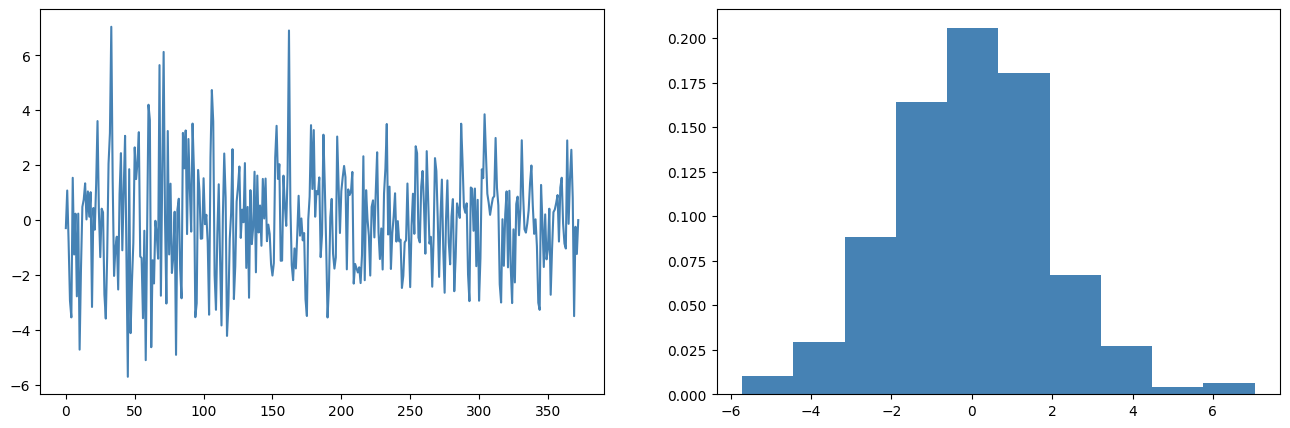

In [224]:
# erros residuais
residuals = [test[i] - predictions[i] for i in range(len(test))]

# converte a lista em um dataframe
residuals = pd.DataFrame(residuals)

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.plot(residuals, color='steelblue')
ax2.hist(residuals, density=True, color='steelblue')

#### 4.1.5.2 Gráfico de autocorrelação

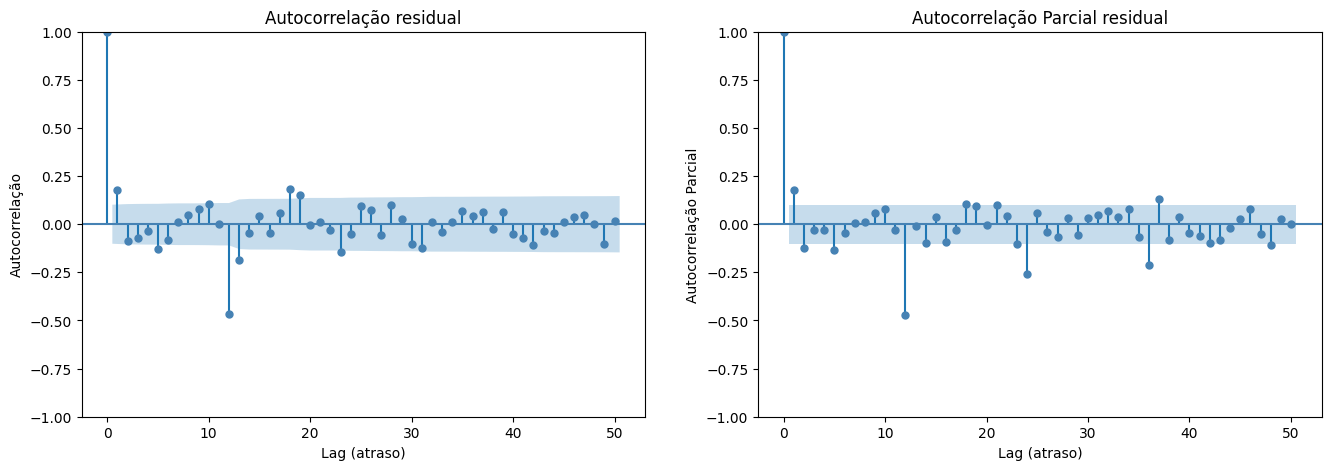

In [225]:
# Criar a figura e os subplots
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plotar o gráfico de autocorrelação
plot_acf(residuals, lags=50, color='steelblue', ax=ax1)
ax1.set_title('Autocorrelação residual')
ax1.set_xlabel('Lag (atraso)')
ax1.set_ylabel('Autocorrelação')

# Plotar o gráfico de autocorrelação parcial
plot_pacf(residuals, lags=50, color='steelblue', ax=ax2)
ax2.set_title('Autocorrelação Parcial residual')
ax2.set_xlabel('Lag (atraso)')
ax2.set_ylabel('Autocorrelação Parcial');

### 4.1.6 Métricas ARIMA

In [226]:
# Calcular o erro quadrático médio (MSE)
mse = mean_squared_error(test, predictions)
# Calcular o erro absoluto médio (MAE)
mae = mean_absolute_error(test, predictions)
# Calcular o coeficiente de determinação (R²)
r2 = r2_score(test, predictions)
# Calcular o erro percentual absoluto médio (MAPE)
mape = np.mean(np.abs((test - predictions) / test)) * 100

print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R²: {r2:.2f}')
print(f'MAPE: {mape:.2f}%')

MSE: 3.82
MAE: 1.53
R²: 0.94
MAPE: 1.35%


## 5.1 Modelo Prophet

### 5.1.1 Ajuste de dados

In [227]:
prophet_b = df1_bovespa.copy()

In [228]:
# Resetar o index
prophet_bovespa = prophet_b.reset_index()
# Ajustar o nome da da colunas data, ultimo para ds, y
prophet_bovespa[['ds','y']] = prophet_bovespa[['data', 'ultimo']]
# Retirar as demais colunas
prophet_bovespa.drop(columns=['data', 'ultimo', 'volume', 'perc_variavel'], axis=1, inplace=True)

In [229]:
prophet_bovespa.dtypes

abertura           float64
maxima             float64
minima             float64
ds          datetime64[ns]
y                  float64
dtype: object

In [230]:
prophet_bovespa.head()

,abertura,maxima,minima,ds,y
0,98.015,98.238,97.083,2019-02-15,97.526
1,97.527,97.527,96.239,2019-02-18,96.510
2,96.513,98.185,96.513,2019-02-19,97.659
3,97.661,98.544,96.545,2019-02-20,96.545
4,96.546,97.231,95.793,2019-02-21,96.932


### 5.1.2 Separação de Treino e teste

In [231]:
train_prophet = prophet_bovespa.sample(frac=0.8, random_state=0)
test_prophet = prophet_bovespa.drop(train_prophet.index)
print(f'train: {train_prophet.shape}')
print(f'test: {test_prophet.shape}')

train: (994, 5)
test: (248, 5)


### 5.1.3 Treinando o Modelo

In [232]:
# Instanciando o Modelo
prophet = Prophet(daily_seasonality=True)

# Treinando o Modelo
prophet.fit(train_prophet)

# Realizando a Previsão 120 dias (4 meses)
df_prev_prophet = prophet.make_future_dataframe(periods=120, freq='D')
prev_prophet = prophet.predict(df_prev_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp1u6ze8ob/q01lxquo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1u6ze8ob/vkj7jp2f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40185', 'data', 'file=/tmp/tmp1u6ze8ob/q01lxquo.json', 'init=/tmp/tmp1u6ze8ob/vkj7jp2f.json', 'output', 'file=/tmp/tmp1u6ze8ob/prophet_model3mq08emr/prophet_model-20240305145205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:52:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:52:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### 5.1.4 Gráfico de Previsão

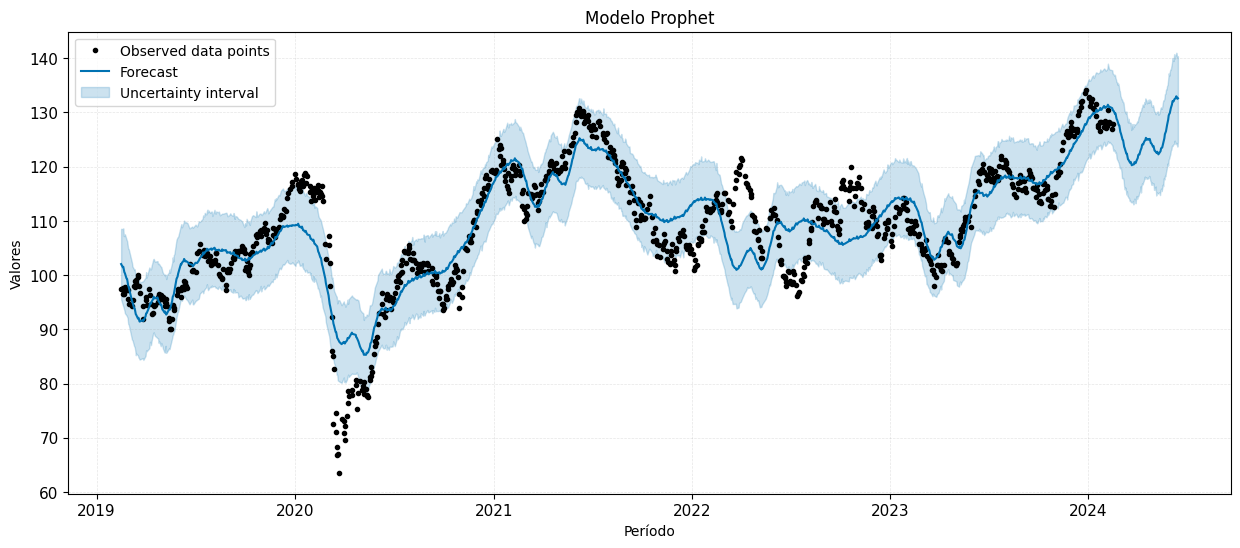

In [233]:
plt.figure(figsize=(15,6))
prophet.plot(prev_prophet, xlabel='Período', ylabel='Valores', ax=plt.gca())
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title('Modelo Prophet', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

### 5.1.5 Grafico de componentes

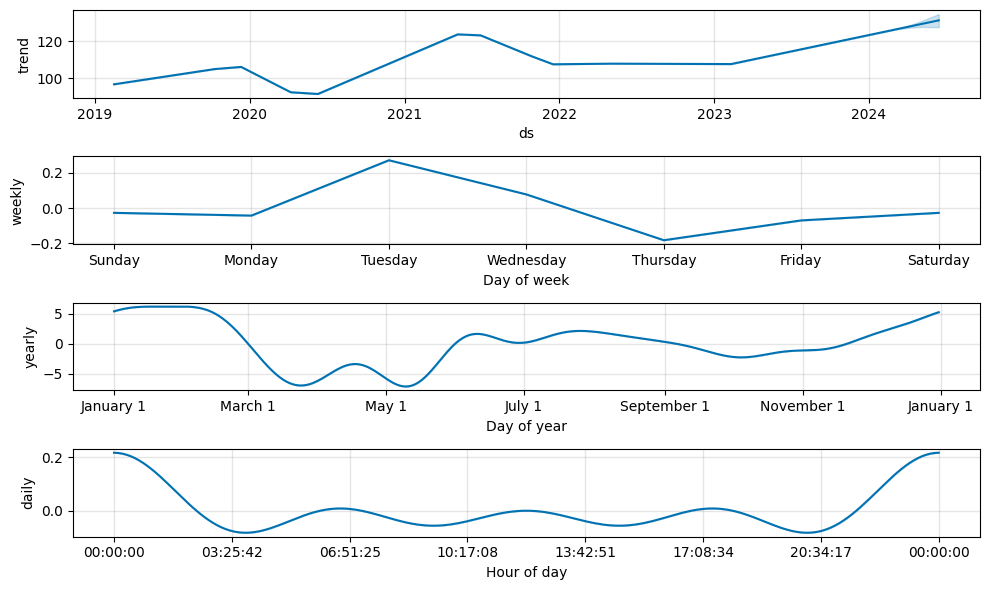

In [234]:
prophet.plot_components(prev_prophet, figsize=(10,6))
plt.show()

### 5.1.6 Métricas Prophet

In [235]:
# Resultados para calcular resultados
result = pd.merge(prev_prophet[['ds', 'yhat']], train_prophet[['ds', 'y']], on='ds', how='inner')

y_result = result['y']
yhat_result = result['yhat']

# Calcular o erro quadrático médio (MSE)
mse = mean_squared_error(y_result, yhat_result)
# Calcular o erro absoluto médio (MAE)
mae = mean_absolute_error(y_result, yhat_result)
# Calcular o coeficiente de determinação (R²)
r2 = r2_score(y_result, yhat_result)
# Calcular o erro percentual absoluto médio (MAPE)
mape = np.mean(np.abs((y_result - yhat_result) / y_result)) * 100


print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R²: {r2:.2f}')
print(f'MAPE: {mape:.2f}%')


MSE: 29.80
MAE: 4.14
R²: 0.78
MAPE: 3.97%


## 6.1 Modelo Ridge regression

In [236]:
# Copiar o data frame df2_bovespa
ridge_bovespa = df1_bovespa.copy()

### 6.1.1 Ajuste e tratamento de dados

* Seleção de Features: As colunas 'abertura', 'máxima', 'mínima', 'volume' e 'perc_variavel’ são removidas
do DataFrame, mantendo apenas a coluna 'último' (valor de fechamento).


In [237]:
ridge_bovespa.drop(columns=['abertura','maxima','minima', 'volume','perc_variavel'], inplace = True)

* Criação do Target: A coluna 'target' é criada, deslocando os valores da coluna 'último' uma posição para
frente, para que cada linha contenha o valor de fechamento do dia seguinte.

* Criação de Médias Móveis: São criadas duas novas features ('mm7d' e 'mm30d') que representam as
médias móveis de 7 e 30 dias, respectivamente, do valor de fechamento.

* Remoção de Valores Nulos: As linhas com valores nulos são removidas.

In [238]:
# Empurrando para frente os valores de fechamento
ridge_bovespa['target'] = ridge_bovespa['ultimo'].shift(-1)

# Criando campos de médias móveis para acrescentar mais features ao modelo
ridge_bovespa['mm7d'] = ridge_bovespa.ultimo.rolling(7).mean()
ridge_bovespa['mm30d'] = ridge_bovespa.ultimo.rolling(30).mean()

# retirando os dados nulos
ridge_bovespa.dropna(inplace=True)
# reset de index
ridge_bovespa.reset_index(inplace =True)

### 6.1.2 Divisão em Conjuntos de Treinamento e Teste

In [239]:
# Separar os dados em variáveis de entrada (X) e variável de saída (y)
X = ridge_bovespa.drop(columns=['data','target', 'mm30d'])
y = ridge_bovespa['target']

In [240]:
# Dividir os dados em conjuntos de treinamento e teste test_size=0.3 indica que 30% dos dados serão usados como conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 6.1.3 Normalização dos Dados

In [241]:
# Gerando o novo padrão
scaler = MinMaxScaler(feature_range= (0,1))
scaled_df = scaler.fit_transform(ridge_bovespa.drop(columns='data'))
scaled_df

array([[0.45995696, 0.45051257, 0.39708602, 0.39132962],
       [0.45051257, 0.43782567, 0.40074901, 0.39005691],
       [0.43782567, 0.46362426, 0.40258715, 0.3888556 ],
       ...,
       [0.91536871, 0.91266425, 0.92730123, 0.983807  ],
       [0.91266425, 0.89839148, 0.92790877, 0.98013703],
       [0.89839148, 0.90952084, 0.92466485, 0.97587265]])

In [242]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((848, 2), (848,), (364, 2), (364,))

### 6.1.4 Criação e Treinamento do Modelo

In [243]:
# Crie um modelo de regressão Ridge com um valor alfa de 1
rg= Ridge(alpha=1.0)

In [244]:
# Ajustar o modelo aos dados de treinamento
rg.fit(X_train, y_train)

# Use o modelo para fazer previsões sobre os dados de teste
y_pred = rg.predict(X_test)

In [245]:
score = rg.score(X_train, y_train)
score

0.9796897768567819

In [246]:
score = rg.score(X_test, y_test)
score

0.9809913610533814

### 6.1.5 Previsões

In [247]:
# Price predicting
prev_preco = rg.predict(X)
prev_preco

array([ 96.05842538,  95.4123287 ,  94.5400243 , ..., 128.21886294,
       128.03322093, 127.04432304])

In [248]:
ridge_bovespa[['data']].shape, prev_preco.shape, y.shape

((1212, 1), (1212,), (1212,))

In [249]:
# Criar um data frame
ridge_prev = ridge_bovespa[['data']]
ridge_prev['ultimo'] = y
ridge_prev['previsao'] = prev_preco
ridge_prev.head()

,data,ultimo,previsao
0,2019-04-01,95.387,96.058425
1,2019-04-02,94.491,95.412329
2,2019-04-03,96.313,94.540024
3,2019-04-04,97.108,96.322329
4,2019-04-05,97.369,97.115040


### 6.1.6 Gráfico de Erro percentual

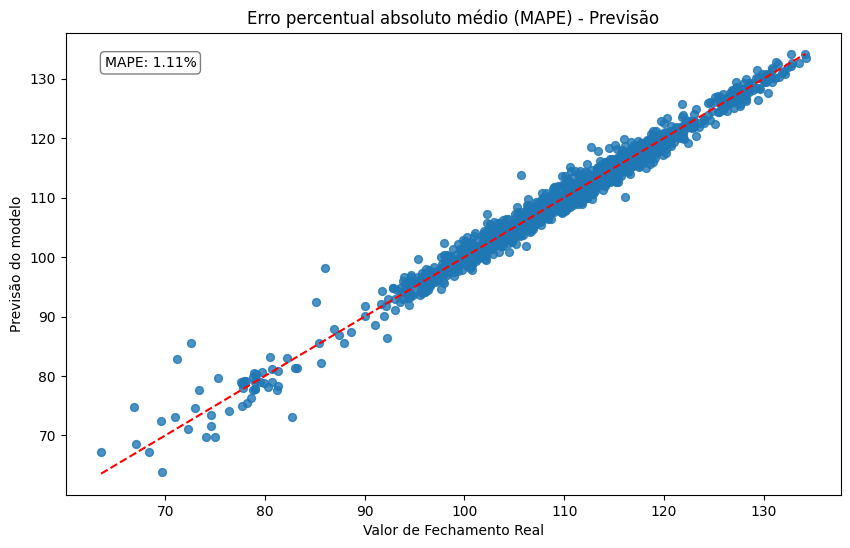

In [250]:
# Calcular o erro percentual absoluto para cada ponto de dados
ridge_prev['erro_percentual_absoluto'] = np.abs((ridge_prev['ultimo'] - ridge_prev['previsao']) / ridge_prev['ultimo']) * 100

# Calcular o MAPE
mape = ridge_prev['erro_percentual_absoluto'].mean()

# Criar figura
plt.figure(figsize=(10, 6))

# Plotar o gráfico de dispersão
plt.scatter(ridge_prev['ultimo'], ridge_prev['previsao'], s=32, alpha=0.8)

# Adicionar linha diagonal (y=x)
plt.plot([ridge_prev['ultimo'].min(), ridge_prev['ultimo'].max()], [ridge_prev['ultimo'].min(), ridge_prev['ultimo'].max()], color='red', linestyle='--')

# Adicionar texto com o MAPE
plt.text(0.05, 0.95, f'MAPE: {mape:.2f}%', transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Configurar o gráfico
plt.xlabel('Valor de Fechamento Real')
plt.ylabel('Previsão do modelo')
plt.title('Erro percentual absoluto médio (MAPE) - Previsão')

# Exibir o gráfico
plt.show()


In [251]:
ridge_prev.tail()

,data,ultimo,previsao,erro_percentual_absoluto
1207,2024-02-06,129.950,130.358991,0.314729
1208,2024-02-07,128.217,129.908519,1.319262
1209,2024-02-08,128.026,128.218863,0.150644
1210,2024-02-09,127.018,128.033221,0.799273
1211,2024-02-14,127.804,127.044323,0.594408


### 6.1.7 Gráfico de Previsão Ridge Regression


In [252]:
# Ordenar os dados previstos pelo índice de data
ridge_prev = ridge_prev.sort_values('data')

# Criar figura
fig = go.Figure()

# Adicionar linha para os valores reais
fig.add_trace(go.Scatter(x=ridge_prev['data'], y=ridge_prev['ultimo'], name='Fechamento Real', line=dict(color='cadetblue')))

# Adicionar linha para as previsões
fig.add_trace(go.Scatter(x=ridge_prev['data'], y=ridge_prev['previsao'], name='Previsão', line=dict(color='tomato')))

# Atualizar layout
fig.update_layout(title='Valor Original vs. Previsão Ridge Regression',
                   xaxis_title='Data',
                   yaxis_title='Valor',
                  #  xaxis=dict(tickformat='%Y-%m', tickangle=45),
                   showlegend=True,
                  #  legend=dict(x=0, y=1, traceorder='normal', font=dict(size=12))
                  )

# Mostrar gráfico
fig.show()


### 6.1.8 Previsão Ridge Regression (Últimos 12 Meses)

In [253]:
# Filtrar os dados para os últimos 12 meses
ultimos_12_meses_rg = ridge_prev[ridge_prev['data'] >= ridge_prev['data'].max() - pd.DateOffset(months=3)]

# Ordenar os dados previstos pelo índice de data
ultimos_12_meses_rg = ultimos_12_meses_rg.sort_values('data')

# Criar figura
fig = go.Figure()

# Adicionar linha para os valores reais
fig.add_trace(go.Scatter(x=ultimos_12_meses_rg['data'], y=ultimos_12_meses_rg['ultimo'], name='Fechamento Real', line=dict(color='cadetblue')))

# Adicionar linha para as previsões
fig.add_trace(go.Scatter(x=ultimos_12_meses_rg['data'], y=ultimos_12_meses_rg['previsao'], name='Previsão', line=dict(color='tomato', dash='dash')))

# Atualizar layout
fig.update_layout(title='Valor Original vs. Previsão Ridge Regression (Últimos 12 Meses)',
                   xaxis_title='Data',
                   yaxis_title='Valor',
                   showlegend=True)

# Mostrar gráfico
fig.show()


### 6.1.9 Metricas Ridge Regression

In [254]:
accuracy = rg.score(X_train, y_train)
print('Ridge Regression score:', accuracy)

Ridge Regression score: 0.9796897768567819


In [255]:
accuracy = rg.score(X_test, y_test)
print('Ridge Regression score:', accuracy)

Ridge Regression score: 0.9809913610533814


In [256]:
# Calcular o erro quadrático médio (MSE)
mse = mean_squared_error(y_test, y_pred)
# Calcular o erro absoluto médio (MAE)
mae = mean_absolute_error(y_test, y_pred)
# Calcular o coeficiente de determinação (R²)
r2 = r2_score(y_test, y_pred)
# Calcular o erro percentual absoluto médio (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R²: {r2:.2f}')
print(f'MAPE: {mape:.2f}%')

MSE: 2.72
MAE: 1.16
R²: 0.98
MAPE: 1.12%


# LSTM

In [257]:
# Copiar o data frame df2_bovespa
lstm_bovespa = df1_bovespa.copy()

In [258]:
#transformar em array
close = lstm_bovespa['ultimo'].to_numpy().reshape(-1,1)

In [259]:
# separar 80% para treinamento
train_close= int(len(close)*0.8)
train_close

993

In [260]:
# Escalar os dados entre 0 e 1 para processamento
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_train = scaler.fit_transform(close[0: train_close, :])
scaler_test = scaler.transform(close[train_close:,:])

scaled_data = list(scaler_train.reshape(len(scaler_train))) + list(scaler_test.reshape(len(scaler_test)))
scaled_data = np.array(scaled_data).reshape(len(scaled_data),1)
scaled_data

array([[0.50525251],
       [0.49013481],
       [0.5072315 ],
       ...,
       [0.95908103],
       [0.94408237],
       [0.95577776]])

In [261]:
# Para o treinamento sera visto 30 dias anteriores
train_data = scaled_data[0: train_close,:]

X_train = []
y_train = []

for i in range(30, len(train_data)):
  X_train.append(train_data[i - 30:i, 0])
  y_train.append(train_data[i, 0])

  if i <= 31:
    print(X_train)
    print(y_train)

[array([0.50525251, 0.49013481, 0.5072315 , 0.4906556 , 0.49641401,
       0.51060917, 0.50099693, 0.50639824, 0.50199387, 0.47635628,
       0.46177425, 0.45601583, 0.45784603, 0.47309764, 0.5127072 ,
       0.50974615, 0.52575663, 0.52130762, 0.52922358, 0.54197542,
       0.53593429, 0.51291551, 0.49339345, 0.44884385, 0.44775764,
       0.47223462, 0.42158438, 0.45857513, 0.47384162, 0.4833497 ])]
[0.4734249918162067]
[array([0.50525251, 0.49013481, 0.5072315 , 0.4906556 , 0.49641401,
       0.51060917, 0.50099693, 0.50639824, 0.50199387, 0.47635628,
       0.46177425, 0.45601583, 0.45784603, 0.47309764, 0.5127072 ,
       0.50974615, 0.52575663, 0.52130762, 0.52922358, 0.54197542,
       0.53593429, 0.51291551, 0.49339345, 0.44884385, 0.44775764,
       0.47223462, 0.42158438, 0.45857513, 0.47384162, 0.4833497 ]), array([0.49013481, 0.5072315 , 0.4906556 , 0.49641401, 0.51060917,
       0.50099693, 0.50639824, 0.50199387, 0.47635628, 0.46177425,
       0.45601583, 0.45784603, 0.47

In [262]:
# Reformular os dados para o formato 3d
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [263]:
# Construir o modelo LSTM
model = Sequential()
model.add(LSTM(units=30, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(10))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 30)            3840      
                                                                 
 lstm_7 (LSTM)               (None, 30, 30)            7320      
                                                                 
 lstm_8 (LSTM)               (None, 30)                7320      
                                                                 
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 18801 (73.44 KB)
Trainable params: 18801 (73.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [264]:
# Treinar o modelo
train_model = model.fit(X_train, y_train, epochs=30, batch_size=10, verbose= 2)

Epoch 1/30
97/97 - 9s - loss: 0.0265 - 9s/epoch - 88ms/step
Epoch 2/30
97/97 - 3s - loss: 0.0065 - 3s/epoch - 26ms/step
Epoch 3/30
97/97 - 3s - loss: 0.0057 - 3s/epoch - 28ms/step
Epoch 4/30
97/97 - 3s - loss: 0.0045 - 3s/epoch - 33ms/step
Epoch 5/30
97/97 - 2s - loss: 0.0036 - 2s/epoch - 25ms/step
Epoch 6/30
97/97 - 2s - loss: 0.0032 - 2s/epoch - 25ms/step
Epoch 7/30
97/97 - 2s - loss: 0.0030 - 2s/epoch - 25ms/step
Epoch 8/30
97/97 - 3s - loss: 0.0024 - 3s/epoch - 32ms/step
Epoch 9/30
97/97 - 3s - loss: 0.0023 - 3s/epoch - 28ms/step
Epoch 10/30
97/97 - 2s - loss: 0.0021 - 2s/epoch - 25ms/step
Epoch 11/30
97/97 - 2s - loss: 0.0021 - 2s/epoch - 25ms/step
Epoch 12/30
97/97 - 2s - loss: 0.0022 - 2s/epoch - 25ms/step
Epoch 13/30
97/97 - 3s - loss: 0.0019 - 3s/epoch - 35ms/step
Epoch 14/30
97/97 - 3s - loss: 0.0019 - 3s/epoch - 26ms/step
Epoch 15/30
97/97 - 2s - loss: 0.0017 - 2s/epoch - 25ms/step
Epoch 16/30
97/97 - 2s - loss: 0.0016 - 2s/epoch - 25ms/step
Epoch 17/30
97/97 - 3s - loss: 0.

In [265]:
test_data = scaled_data[train_close - 30:, :]

X_test = []
y_test = close[train_close:,:]

for i in range(30, len(test_data)):
  X_test.append(test_data[i - 30: i, 0])

In [266]:
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [267]:
# Criar a predição
prev_lstm = model.predict(X_test)

# Inverter os dados da predição
prev_lstm = scaler.inverse_transform(prev_lstm)

prev_lstm

8/8 [==============================] - 1s 11ms/step


array([[106.67641 ],
       [106.89534 ],
       [106.56798 ],
       [107.31701 ],
       [108.099884],
       [107.983925],
       [106.56543 ],
       [105.97403 ],
       [104.91587 ],
       [104.30433 ],
       [103.71075 ],
       [103.134415],
       [102.290085],
       [102.112465],
       [102.641815],
       [102.81423 ],
       [104.03241 ],
       [104.111176],
       [103.06332 ],
       [102.05848 ],
       [101.53293 ],
       [101.286194],
       [101.6398  ],
       [101.22977 ],
       [100.27758 ],
       [ 99.71028 ],
       [ 99.15276 ],
       [ 97.74454 ],
       [ 97.20351 ],
       [ 97.58285 ],
       [ 98.7726  ],
       [ 99.949585],
       [101.49817 ],
       [101.52957 ],
       [100.90568 ],
       [100.62882 ],
       [100.18465 ],
       [ 99.846146],
       [100.22232 ],
       [102.81038 ],
       [105.13985 ],
       [105.93367 ],
       [105.77395 ],
       [105.32974 ],
       [105.16109 ],
       [103.956215],
       [103.38667 ],
       [103.0

In [268]:
# Calcular o erro quadrático médio (MSE)
mse = mean_squared_error(y_test, prev_lstm)
# Calcular o erro absoluto médio (MAE)
mae = mean_absolute_error(y_test, prev_lstm)
# Calcular o coeficiente de determinação (R²)
r2 = r2_score(y_test, prev_lstm)
# Calcular o erro percentual absoluto médio (MAPE)
mape = np.mean(np.abs((y_test - prev_lstm) / y_test)) * 100

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")
print(f"MAPE: {mape:.2f}%")

MSE: 4.25
MAE: 1.70
R²: 0.95
MAPE: 1.45%


In [269]:
train_g = lstm_bovespa.iloc[: train_close, :]
test_g = pd.DataFrame({"ultimo":lstm_bovespa['ultimo'].iloc[train_close:],"previsao":prev_lstm.reshape(len(prev_lstm))})

In [270]:
# Criar a figura
fig = go.Figure()

# Adicionar as séries de dados ao gráfico
fig.add_trace(go.Scatter(x=train_g.index, y=train_g['ultimo'], mode='lines', name='Treinamento'))
fig.add_trace(go.Scatter(x=test_g.index, y=test_g['ultimo'], mode='lines', name='Valor Real'))
fig.add_trace(go.Scatter(x=test_g.index, y=test_g['previsao'], mode='lines', name='Previsão'))

# Atualizar layout do gráfico
fig.update_layout(title='Previsão LSTM ', xaxis_title='Período', yaxis_title='Fechamento')

# Exibir o gráfico
fig.show()

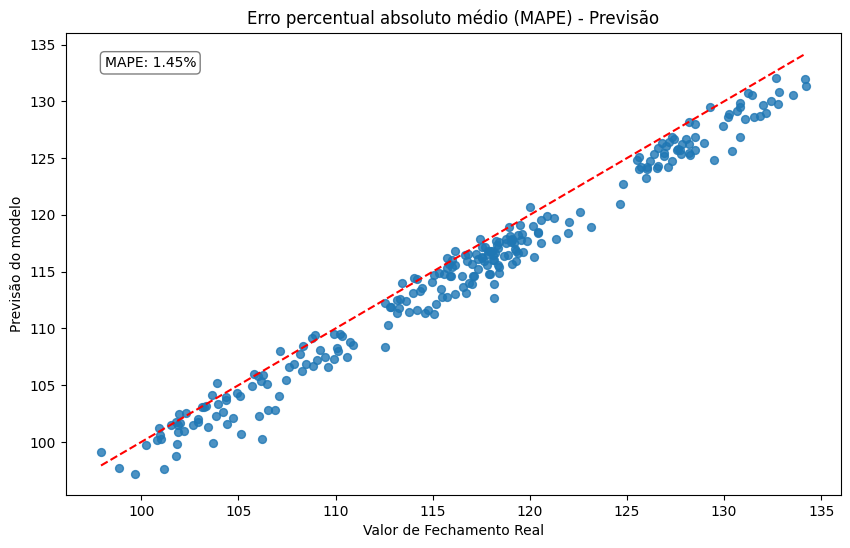

In [271]:
# Calcular o erro percentual absoluto para cada ponto de dados
test_g['erro_percentual_absoluto'] = np.abs((test_g['ultimo'] - test_g['previsao']) / test_g['ultimo']) * 100

# Calcular o MAPE
mape = test_g['erro_percentual_absoluto'].mean()

# Criar figura
plt.figure(figsize=(10, 6))

# Plotar o gráfico de dispersão
plt.scatter(test_g['ultimo'], test_g['previsao'], s=32, alpha=0.8)

# Adicionar linha diagonal (y=x)
plt.plot([test_g['ultimo'].min(), test_g['ultimo'].max()], [test_g['ultimo'].min(), test_g['ultimo'].max()], color='red', linestyle='--')

# Adicionar texto com o MAPE
plt.text(0.05, 0.95, f'MAPE: {mape:.2f}%', transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Configurar o gráfico
plt.xlabel('Valor de Fechamento Real')
plt.ylabel('Previsão do modelo')
plt.title('Erro percentual absoluto médio (MAPE) - Previsão')

# Exibir o gráfico
plt.show()

In [272]:
test_g.head()

,ultimo,previsao,erro_percentual_absoluto
data,,,
2023-02-13,108.836,106.676407,1.984264
2023-02-14,107.849,106.895340,0.884255
2023-02-15,109.600,106.567978,2.766444
2023-02-16,109.941,107.317009,2.386727
2023-02-17,109.177,108.099884,0.986578


# Previsão para futuro

In [273]:
today = datetime.now()

today = datetime.now() - timedelta(days=1)

if today.hour > 18:
  final = today
  start = datetime.now() - timedelta(days=252)

last_30_days = close.copy()

last_30_days_scaler = scaler.transform(last_30_days)

X_test = []
X_test.append(last_30_days_scaler)
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Criar a predição
prev_future = model.predict(X_test)

# Inverter os dados da predição
prev_future = scaler.inverse_transform(prev_future)

print(prev_future)

1/1 [==============================] - 1s 1s/step
[[125.68894]]


# Conclusão

Em conclusão a análise e previsão do índice Bovespa utilizando os modelos ARIMA, Prophet, LSTM e Ridge Regression revelou insights importantes para compreender o comportamento do mercado financeiro brasileiro. A escolha desses modelos baseou-se em critérios como robustez, adaptabilidade, eficiência computacional, capacidade de generalização e precisão da previsão.

O modelo ARIMA mostrou-se eficaz na captura de padrões de autocorrelação e tendências da série temporal do índice Bovespa, apresentando métricas satisfatórias, como um Erro Quadrático Médio (MSE) de 3.82, Erro Absoluto Médio (MAE) de 1.53, Coeficiente de Determinação (R²) de 0.94 e Erro Percentual Absoluto Médio (MAPE) de 1.35%.

Por outro lado, o modelo Prophet, desenvolvido pelo Facebook, destacou-se pela capacidade de lidar com diferentes tipos de sazonalidade, feriados e tendências de longo prazo, mesmo para usuários sem experiência avançada em ciência de dados. No entanto, apresentou métricas de erro um pouco mais elevadas, com um MSE de 29.80, MAE de 4.14, R² de 0.78 e MAPE de 3.97%.


O modelo LSTM obteve resultados bastante promissores na previsão do preço de fechamento da ação, com um erro médio quadrático (MSE) de 4.25 e um erro absoluto médio (MAE) de 1.70. Além disso, o coeficiente de determinação (R²) de 0.95 indica que o modelo é capaz de explicar 94% da variância dos dados, demonstrando uma boa capacidade de ajuste aos dados observados. O erro percentual absoluto médio (MAPE) de 1.45% indica que, em média, as previsões do modelo estão muito próximas dos valores reais, sugerindo que o modelo LSTM é eficaz na previsão de preços de ações.

Já a Ridge Regression, uma técnica de regressão linear regularizada, mostrou-se eficiente para evitar o overfitting e lidar com multicolinearidade nos dados, apresentando métricas de erro bastante baixas, com um MSE de 2.72, MAE de 1.16, R² de 0.98 e MAPE de 1.12%.
Esses resultados indicam que o modelo Ridge Regression foi o mais preciso na previsão do índice Bovespa, seguido pelo LSTM, ARIMA e Prophet. No entanto, cada modelo possui suas vantagens e limitações, e a escolha do modelo ideal deve levar em consideração o contexto específico da análise e os objetivos do estudo.

Em suma, a combinação desses modelos pode fornecer uma visão mais abrangente e robusta do comportamento do mercado financeiro, auxiliando investidores, analistas e tomadores de decisão a compreender e antecipar as tendências do índice Bovespa.
